In [5]:
import numpy as np
import pandas as pd

In [11]:
df = pd.read_csv("../../datasets/Stammdaten.csv", low_memory=False)

In [12]:
# Display data types of columns in the DataFrame
print(df.dtypes)


Materialnummer               object
Lieferant OB                  int64
Vertrag OB                  float64
Vertragsposition OB           int64
Planlieferzeit Vertrag        int64
Vertrag Fix1                  int64
Vertrag_Fix2                  int64
Beschaffungsart              object
Sonderbeschaffungsart       float64
Disponent                     int64
Einkäufer                   float64
DispoGruppe                  object
Dispolosgröße                object
Gesamtbestand                 int64
Gesamtwert                    int64
Preiseinheit                  int64
Kalender                     object
Werk OB                       int64
Werk Infosatz               float64
Infosatznummer              float64
Infosatztyp                 float64
WE-Bearbeitungszeit           int64
Planlieferzeit Mat-Stamm      int64
Warengruppe                  object
Basiseinheit                 object
dtype: object


In [13]:
# Drop columns with NaN values
data = df.dropna(axis=1)
    
categorical_columns = ["Materialnummer", "Lieferant OB", "Vertragsposition OB", "Beschaffungsart", "Disponent", "Einkäufer", "Dispolosgröße", "Werk OB", "Warengruppe", "Basiseinheit"]
numerical_columns = ["Planlieferzeit Vertrag", "Vertrag Fix1", "Vertrag_Fix2", "Gesamtbestand", "Gesamtwert", "Preiseinheit", "WE-Bearbeitungszeit", "Planlieferzeit Mat-Stamm"]
    
data[categorical_columns] = data[categorical_columns].astype('category')
data[numerical_columns] = data[numerical_columns].astype('int64')

C:\Users\Raoul\AppData\Local\Temp\ipykernel_6440\3875527836.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[categorical_columns] = data[categorical_columns].astype('category')
C:\Users\Raoul\AppData\Local\Temp\ipykernel_6440\3875527836.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numerical_columns] = data[numerical_columns].astype('int64')


C:\Users\Raoul\AppData\Local\Temp\ipykernel_6440\546246274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col + '_z_score'] = np.abs(stats.zscore(data[col]))
C:\Users\Raoul\AppData\Local\Temp\ipykernel_6440\546246274.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col + '_outlier'] = 0
C:\Users\Raoul\AppData\Local\Temp\ipykernel_6440\546246274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

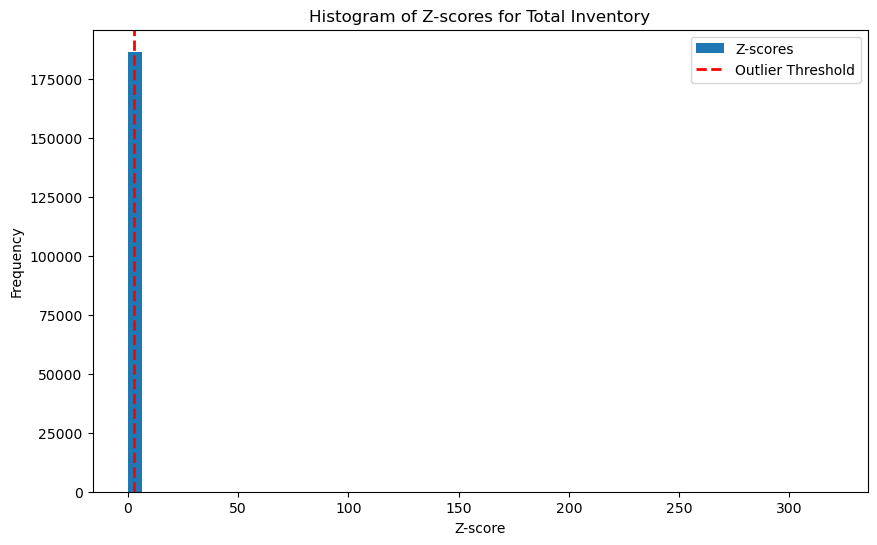

In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
from scipy import stats
import matplotlib.pyplot as plt

# Encode categorical variables
#categorical_columns = data.select_dtypes(include=['object']).columns
#data[categorical_columns] = data[categorical_columns].apply(lambda col: pd.factorize(col)[0])


# Handling missing values by replacing them with the median of each column
for col in numerical_columns:
    if data[col].isna().any():
        data[col].fillna(data[col].median(), inplace=True)

# Applying Z-score for anomaly detection in numeric columns
for col in numerical_columns:
    data[col + '_z_score'] = np.abs(stats.zscore(data[col]))
    data[col + '_outlier'] = 0
    data.loc[data[col + '_z_score'] > 3, col + '_outlier'] = 1  # Any Z-score > 3 is considered an outlier

# Combine all outlier flags to a single anomaly label
data['anomaly_label'] = data[[col + '_outlier' for col in numerical_columns]].max(axis=1)

# Train XGBoost model for anomaly detection
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(data[numerical_columns], data['anomaly_label'])

# Predict anomaly labels using XGBoost
data['xgb_anomaly'] = xgb_model.predict(data[numerical_columns])

# Visualize statistical outliers in one of the numeric columns
plt.figure(figsize=(10, 6))
plt.hist(data['Gesamtbestand_z_score'], bins=50, label='Z-scores')
plt.axvline(3, color='red', linestyle='dashed', linewidth=2, label='Outlier Threshold')
plt.title('Histogram of Z-scores for Total Inventory')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Save the updated dataset
data.to_csv('updated_with_anomalies_xgboost_stammdaten.csv', index=False)


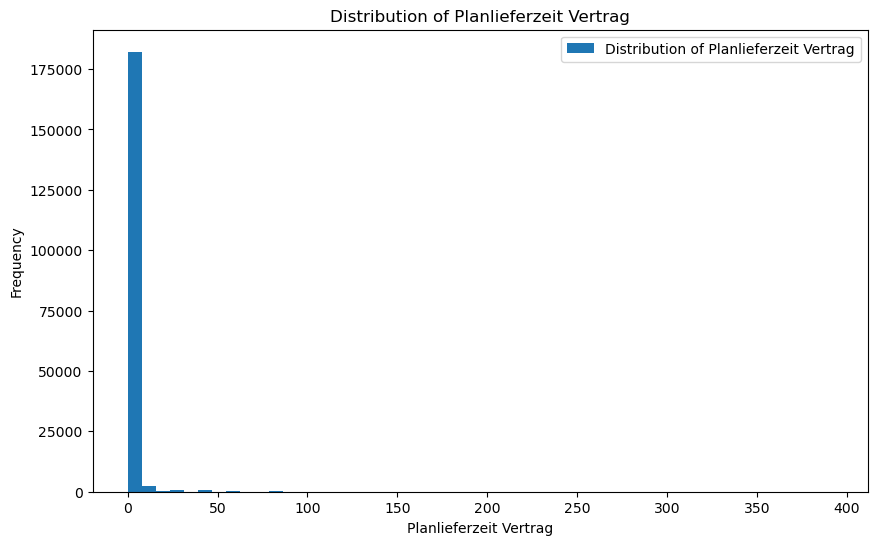

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from scipy import stats
import matplotlib.pyplot as plt

# Handling missing values by replacing them with the median of each column
for col in numerical_columns:
    if data[col].isna().any():
        data[col].fillna(data[col].median(), inplace=True)

# Applying Z-score for anomaly detection in numeric columns
for col in numerical_columns:
    data[col + '_z_score'] = np.abs(stats.zscore(data[col]))
    data[col + '_outlier'] = 0
    data.loc[data[col + '_z_score'] > 3, col + '_outlier'] = 1  # Any Z-score > 3 is considered an outlier

# Combine all outlier flags to a single anomaly label
data['anomaly_label'] = data[[col + '_outlier' for col in numerical_columns]].max(axis=1)

# Train Isolation Forest model for anomaly detection
if_model = IsolationForest(random_state=42)
if_model.fit(data[numerical_columns])

# Predict anomaly labels using Isolation Forest
data['if_anomaly'] = if_model.predict(data[numerical_columns])
data['if_anomaly'] = np.where(data['if_anomaly'] == -1, 1, 0)  # Convert -1 to 1 for anomaly, 1 to 0 for normal

# Find the top 5 columns with the most anomalies predicted by Isolation Forest
top_5_columns = np.argsort(np.sum(np.abs(if_model.decision_function(data[numerical_columns]))))

# Plot the distributions of the top 5 most anomalous columns
for col_index in top_5_columns[:5]:
    column_name = numerical_columns[col_index]
    plt.figure(figsize=(10, 6))
    plt.hist(data[column_name], bins=50, label=f'Distribution of {column_name}')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'{column_name}_distribution.png')
    plt.show()

# Save the updated dataset
data.to_csv('updated_with_anomalies_iforest_stammdaten.csv', index=False)


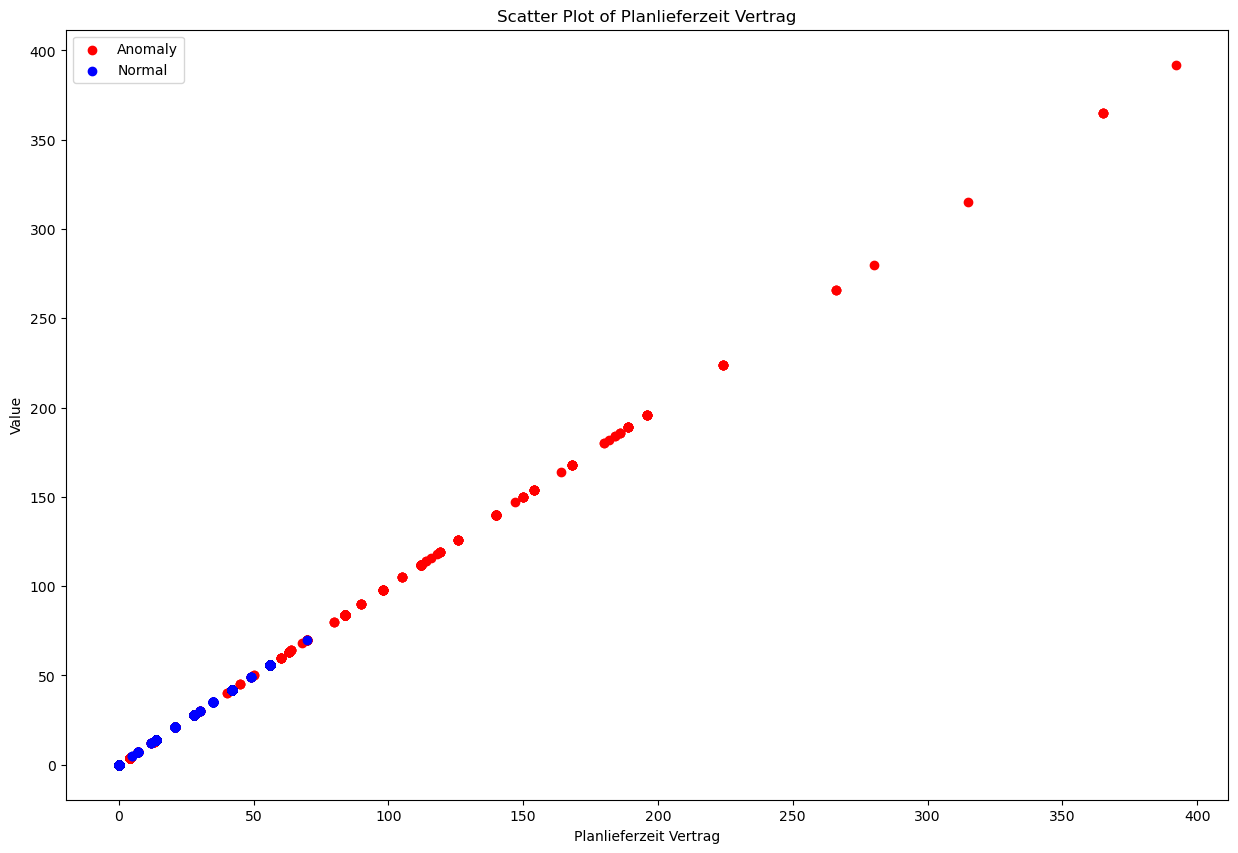

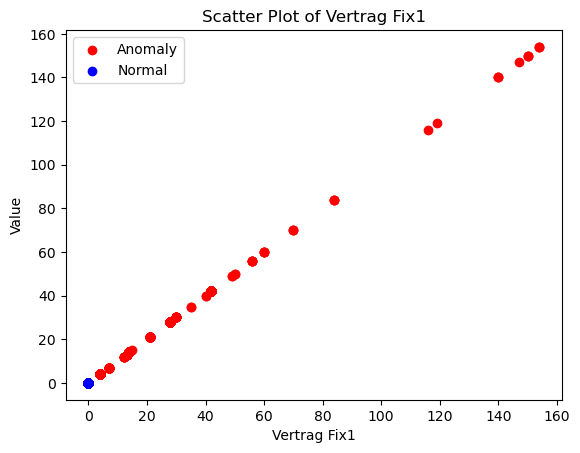

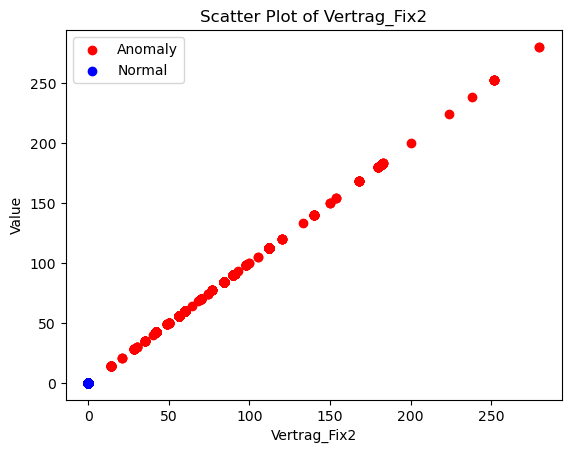

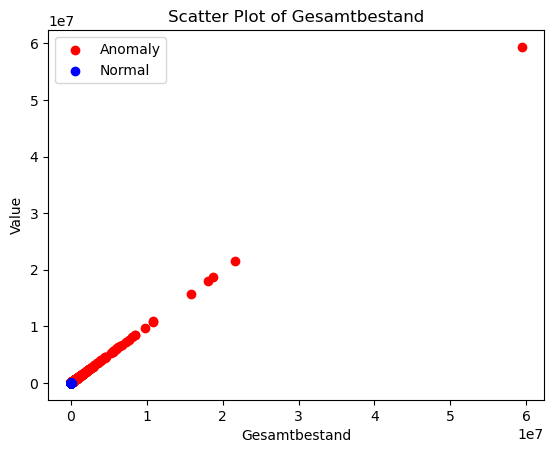

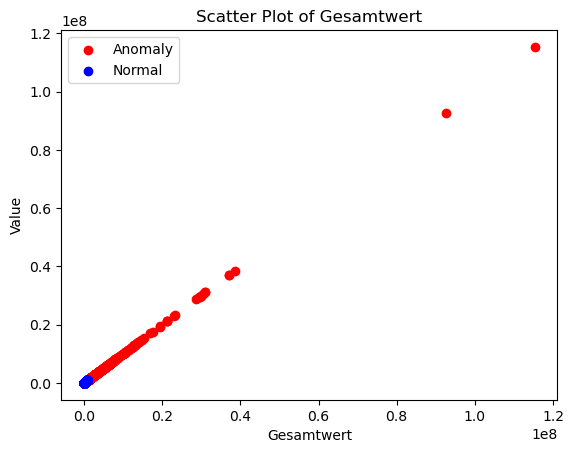

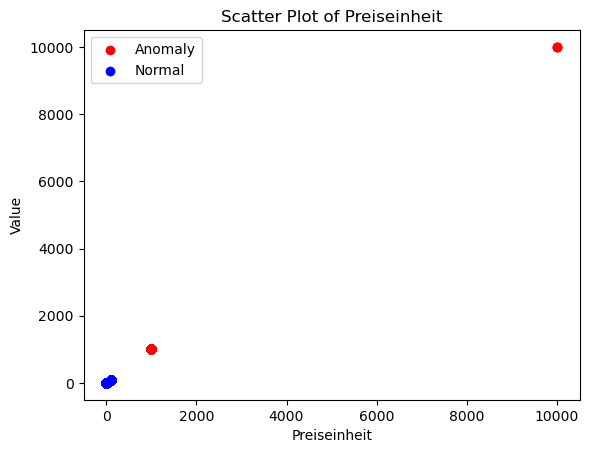

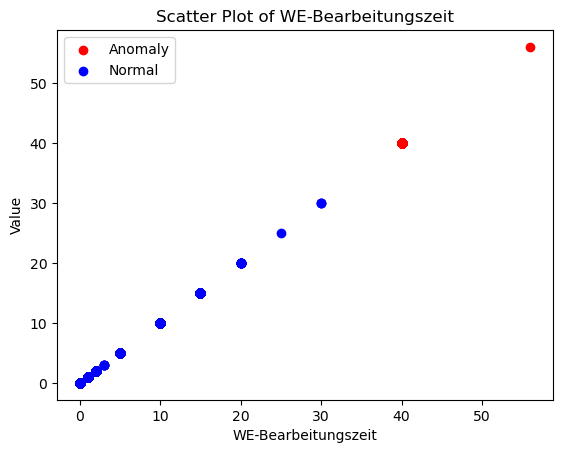

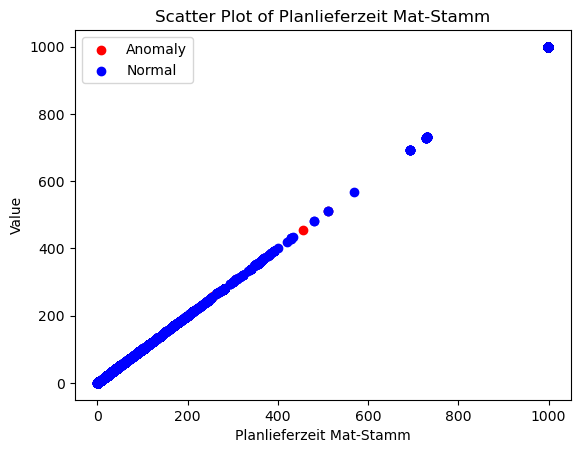

In [16]:
# Scatter plots for detected anomalies
plt.figure(figsize=(15, 10))
for col_index in range(len(numerical_columns)):
    column_name = numerical_columns[col_index]
    # Plot anomalies detected by XGBoost
    plt.scatter(data[column_name][data['if_anomaly'] == 1], data[column_name][data['if_anomaly'] == 1], c='red', label='Anomaly')
    # Plot normal data points
    plt.scatter(data[column_name][data['if_anomaly'] == 0], data[column_name][data['if_anomaly'] == 0], c='blue', label='Normal')
    plt.xlabel(column_name)
    plt.ylabel('Value')
    plt.title(f'Scatter Plot of {column_name}')
    plt.legend()
    plt.savefig(f'{column_name}_scatter.png')
    plt.show()

In [17]:
# Calculate ratios of detected anomalies on each column
anomaly_ratios = (data.filter(regex='_outlier$').sum() / len(data)).sort_values(ascending=False)

# Identify the most bizarre values of each column
most_bizarre_values = {}
for col in numerical_columns:
    # Calculate Z-score for each column
    z_scores = np.abs(stats.zscore(data[col]))
    # Identify the most bizarre value
    most_bizarre_value = data.loc[np.argmax(z_scores), col]
    most_bizarre_values[col] = most_bizarre_value

# Write the report to a text file
with open("anomaly_report_iforest.txt", "w") as f:
    f.write("Anomaly Ratios:\n")
    for col, ratio in anomaly_ratios.items():
        f.write(f"{col}: {ratio:.2f}\n")
    f.write("\nMost Bizarre Values:\n")
    for col, value in most_bizarre_values.items():
        f.write(f"{col}: {value}\n")
        f.write(f"Description: This value might occur due to ...\n\n")

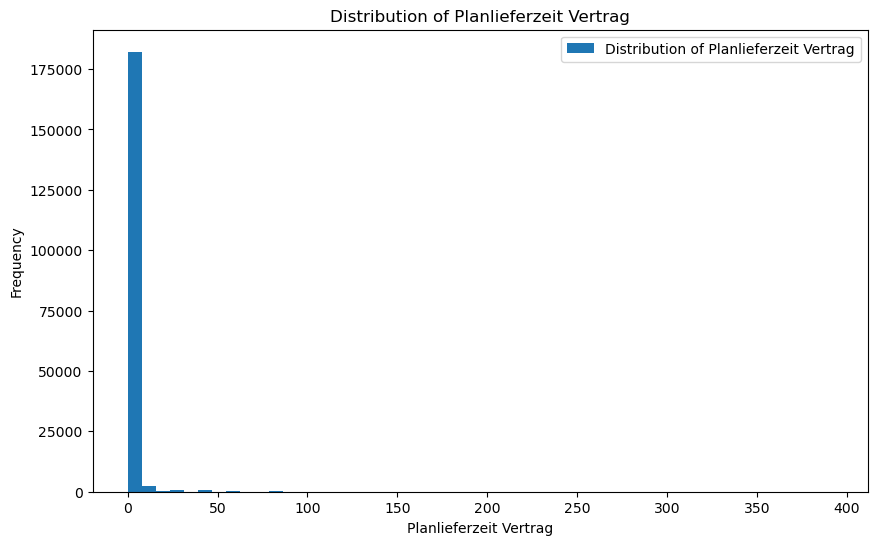

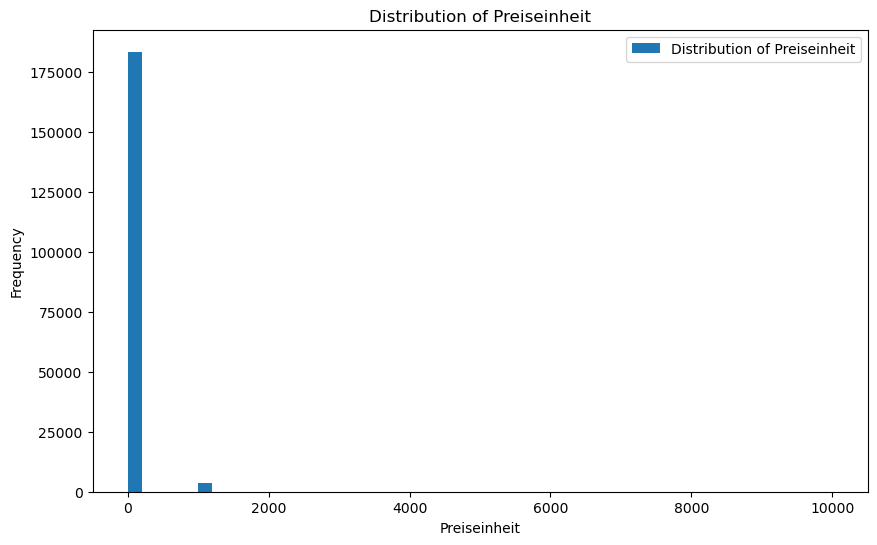

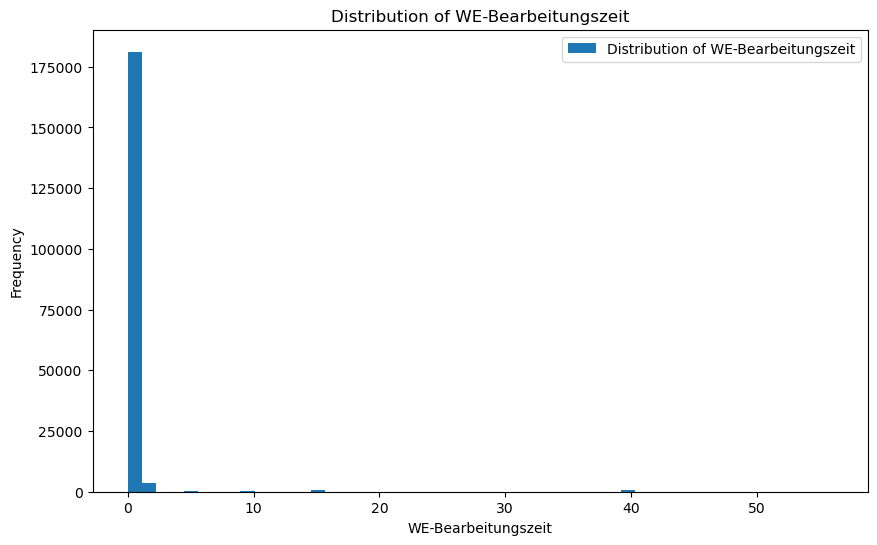

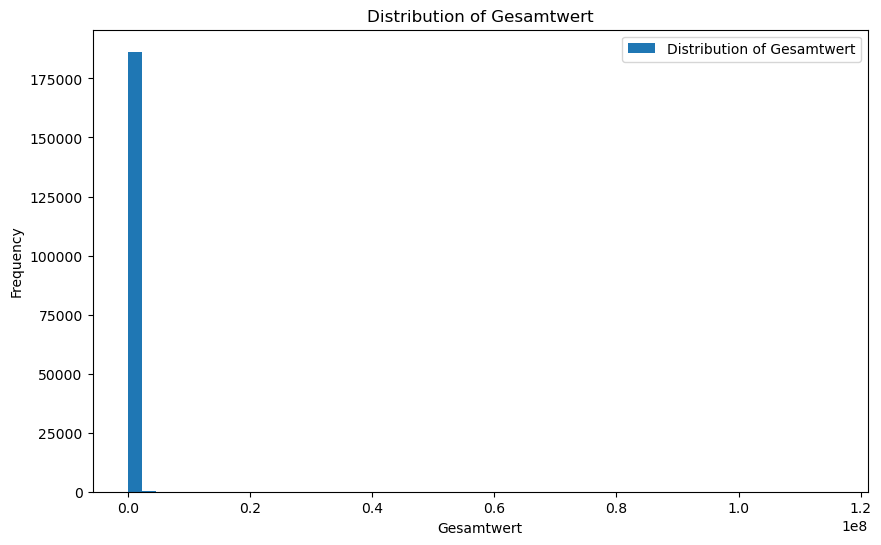

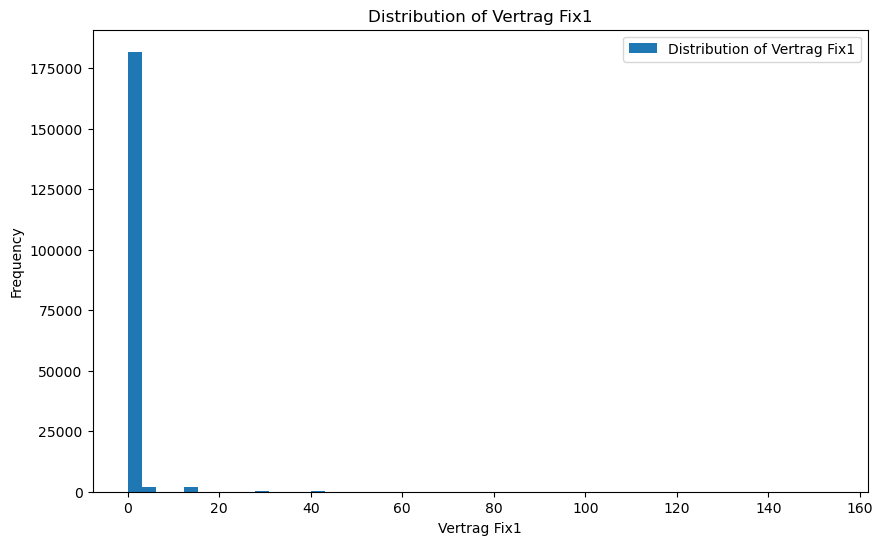

In [18]:
import pandas as pd
import numpy as np
import xgboost as xgb
from scipy import stats
import matplotlib.pyplot as plt

# Handling missing values by replacing them with the median of each column
for col in numerical_columns:
    if data[col].isna().any():
        data[col].fillna(data[col].median(), inplace=True)

# Applying Z-score for anomaly detection in numeric columns
for col in numerical_columns:
    data[col + '_z_score'] = np.abs(stats.zscore(data[col]))
    data[col + '_outlier'] = 0
    data.loc[data[col + '_z_score'] > 3, col + '_outlier'] = 1  # Any Z-score > 3 is considered an outlier

# Combine all outlier flags to a single anomaly label
data['anomaly_label'] = data[[col + '_outlier' for col in numerical_columns]].max(axis=1)

# Train XGBoost model for anomaly detection
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(data[numerical_columns], data['anomaly_label'])

# Predict anomaly labels using XGBoost
data['xgb_anomaly'] = xgb_model.predict(data[numerical_columns])

# Find the top 5 columns with the most anomalies predicted by XGBoost
top_5_columns = xgb_model.feature_importances_.argsort()[-5:][::-1]

# Plot the distributions of the top 5 most anomalous columns
for col_index in top_5_columns:
    column_name = numerical_columns[col_index]
    plt.figure(figsize=(10, 6))
    plt.hist(data[column_name], bins=50, label=f'Distribution of {column_name}')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'{column_name}_distribution.png')
    plt.show()

# Save the updated dataset
data.to_csv('updated_with_anomalies_xgboost_stammdaten.csv', index=False)


In [24]:
def calculate_performance(predictions, y_test):
    # Calculate the percentage of matching entries
    matching_percentage = (y_test == predictions).mean() * 100
    print(f"Percentage of matching entries (accuracy): {matching_percentage:.2f}%")

    # Calculate precision components
    matching_ones = (y_test == 1) & (predictions == 1)
    amount_anomalies_in_predictions = sum(predictions == 1)
    count_matching_ones = matching_ones.sum()

    # Calculate precision
    if amount_anomalies_in_predictions > 0:
        precision = (count_matching_ones / amount_anomalies_in_predictions) * 100
    else:
        precision = 0
    print(f"Percent of matching anomalies (precision): {precision:.2f}%")

    # Calculate false negatives
    false_negatives = sum((y_test == 1) & (predictions == 0))
    print(f"Number of false negatives: {false_negatives}")

    # Calculate percentage of anomalies in predictions and validation data
    percent_anomalies_in_predictions = (amount_anomalies_in_predictions / len(predictions)) * 100
    percent_anomalies_in_validation = (sum(y_test == 1) / len(y_test)) * 100
    print(f"Percent of anomalies in predictions: {percent_anomalies_in_predictions:.2f}%")
    print(f"Percent of anomalies in validation data: {percent_anomalies_in_validation:.2f}%")
    print(f"Recall: {100*count_matching_ones/(count_matching_ones+false_negatives):.2f}%")
    print("\n")


if_predictions = data["if_anomaly"]
xgb_predictions = data["xgb_anomaly"]
y_test = data["anomaly_label"]
calculate_performance(if_predictions, y_test)
calculate_performance(xgb_predictions, y_test)

Percentage of matching entries (accuracy): 97.97%
Percent of matching anomalies (precision): 83.22%
Number of false negatives: 1683
Percent of anomalies in predictions: 6.70%
Percent of anomalies in validation data: 6.48%
Recall: 86.09%


Percentage of matching entries (accuracy): 100.00%
Percent of matching anomalies (precision): 99.99%
Number of false negatives: 3
Percent of anomalies in predictions: 6.48%
Percent of anomalies in validation data: 6.48%
Recall: 99.98%




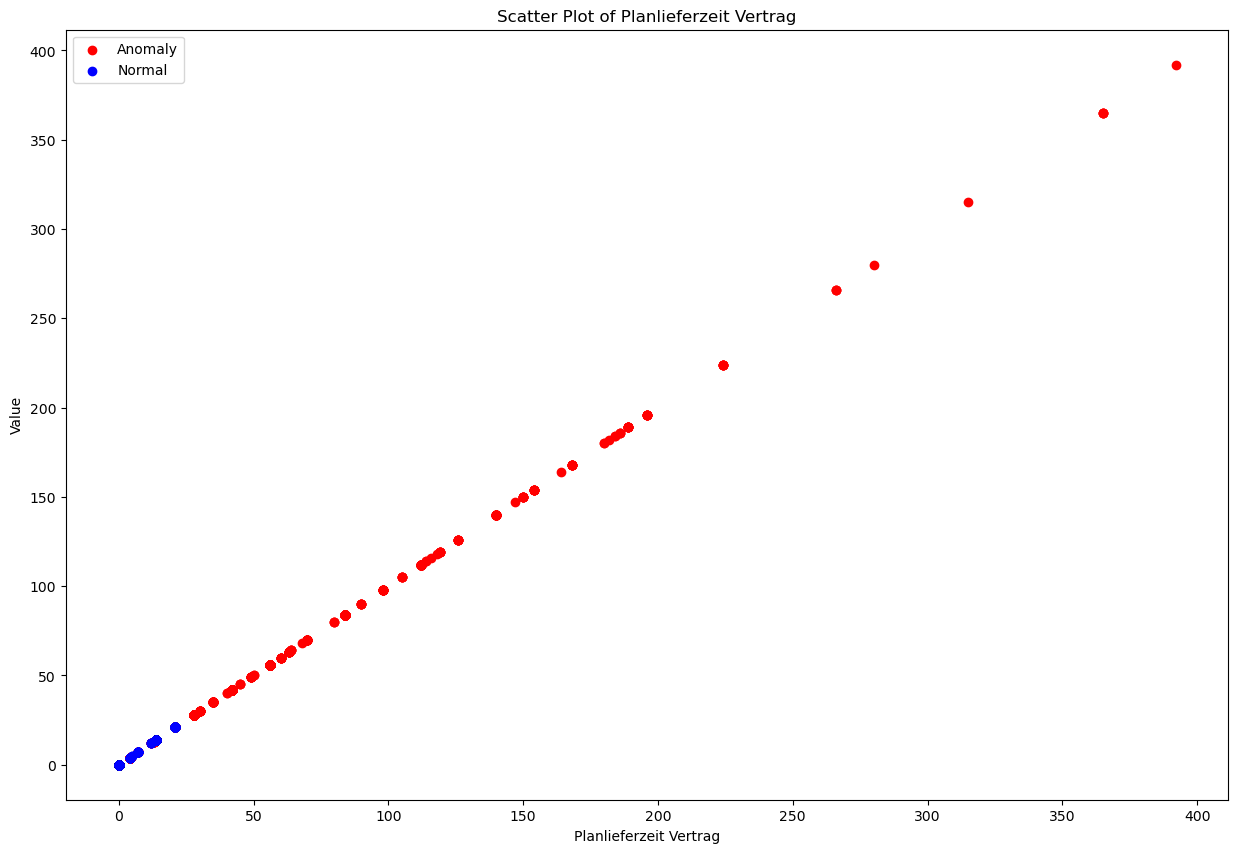

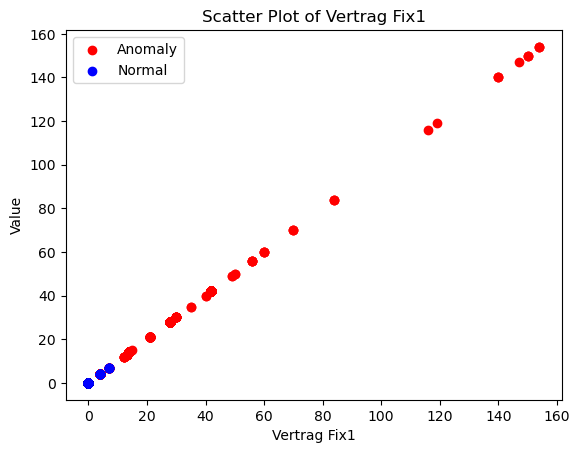

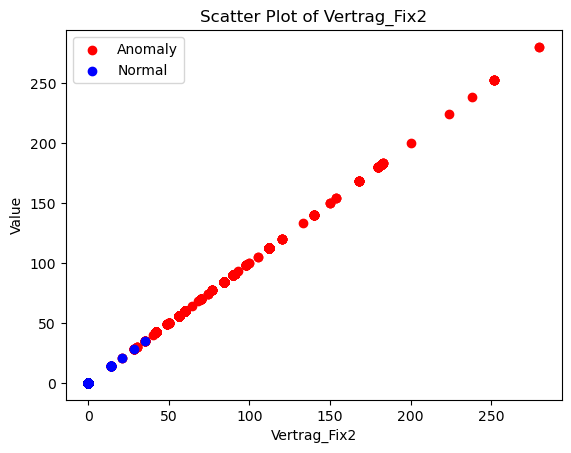

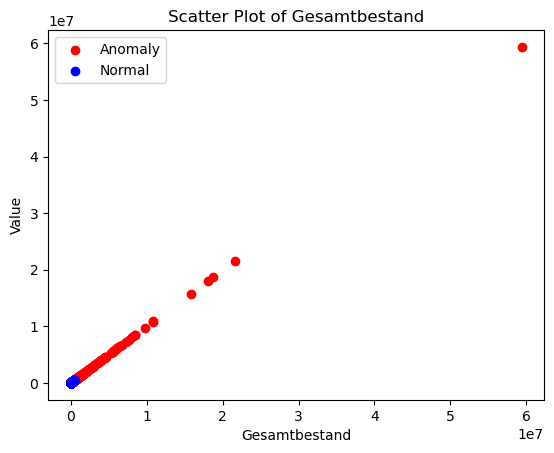

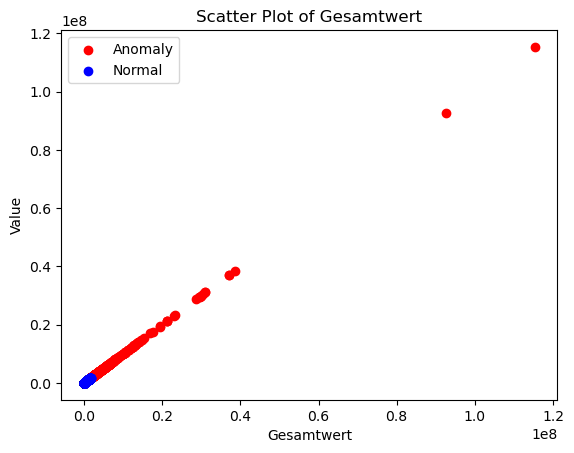

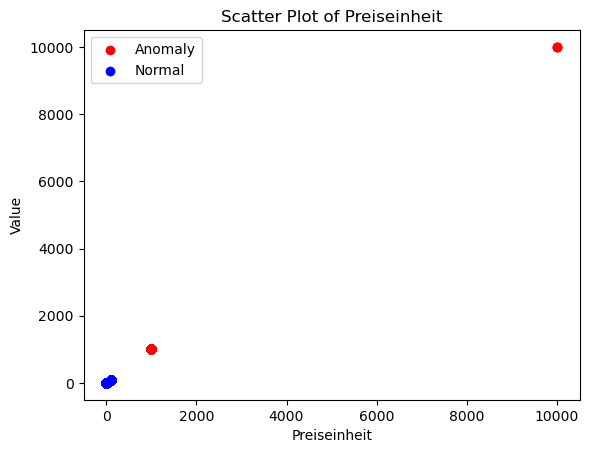

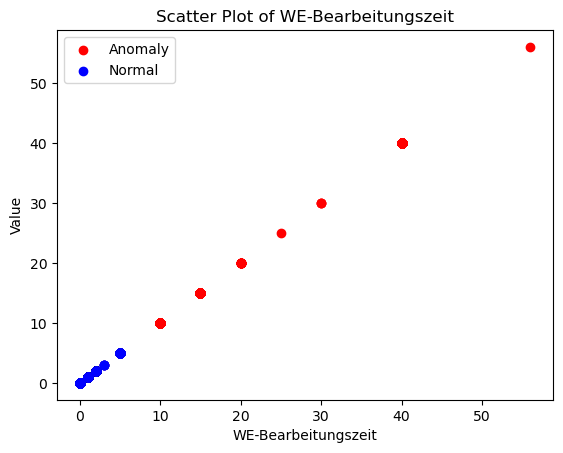

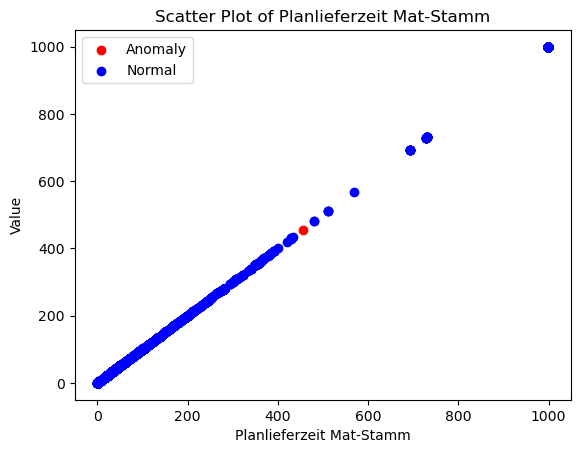

In [19]:
# Scatter plots for detected anomalies
plt.figure(figsize=(15, 10))
for col_index in range(len(numerical_columns)):
    column_name = numerical_columns[col_index]
    # Plot anomalies detected by XGBoost
    plt.scatter(data[column_name][data['xgb_anomaly'] == 1], data[column_name][data['xgb_anomaly'] == 1], c='red', label='Anomaly')
    # Plot normal data points
    plt.scatter(data[column_name][data['xgb_anomaly'] == 0], data[column_name][data['xgb_anomaly'] == 0], c='blue', label='Normal')
    plt.xlabel(column_name)
    plt.ylabel('Value')
    plt.title(f'Scatter Plot of {column_name}')
    plt.legend()
    plt.savefig(f'{column_name}_scatter.png')
    plt.show()


In [20]:
# Calculate ratios of detected anomalies on each column
anomaly_ratios = (data.filter(regex='_outlier$').sum() / len(data)).sort_values(ascending=False)

# Identify the most bizarre values of each column
most_bizarre_values = {}
for col in numerical_columns:
    # Calculate Z-score for each column
    z_scores = np.abs(stats.zscore(data[col]))
    # Identify the most bizarre value
    most_bizarre_value = data.loc[np.argmax(z_scores), col]
    most_bizarre_values[col] = most_bizarre_value

# Write the report to a text file
with open("anomaly_report.txt", "w") as f:
    f.write("Anomaly Ratios:\n")
    for col, ratio in anomaly_ratios.items():
        f.write(f"{col}: {ratio:.2f}\n")
    f.write("\nMost Bizarre Values:\n")
    for col, value in most_bizarre_values.items():
        f.write(f"{col}: {value}\n")
        f.write(f"Description: This value might occur due to ...\n\n")